# Demonstration of distribution reweighting

    xgboost is used to train the data and mc sample.
    data is shuffled before divided into train test and validation part
    root_numpy and pandas are used to hadle root files.
    sklearn is partly used.

In [1]:
%pylab inline
figsize(16, 8)

from __future__ import division
import xgboost as xgb 
from xgboost import plot_importance
from xgboost import plot_tree
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
import pandas as pd
import root_numpy

Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.12/04


In [2]:
import matplotlib.pyplot as plt
hist_settings = {'bins': 100, 'normed': True, 'alpha': 0.5}
def draw_distributions(original, target, new_original_weights, fig_name):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    for id, column in enumerate(columns_draw, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99]) #percentile is to calculate the p% number of a givening array
        ax=plt.subplot(6, 5, id) 
        hist(target[column], range=xlim, **hist_settings)
        hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)  #hist is to plot the histogram (matplotlib)
        
        plt.title(columns_draw[id-1],fontsize=20)
        tight_layout() #distance between different figs
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        # 设置坐标标签字体大小
        #ax.set_xlabel('', fontsize=20)
        #ax.set_ylabel('', fontsize=20)
        # 设置图例字体大小
        #ax.legend('', fontsize=20)    
    savefig(fig_name)

## Prepare for data
    

In [3]:
columns_draw = ['ct_g','ct_eta','Px_g','Py_g','Pz_g','E_g','Px_eta','Py_eta','Pz_eta','E_eta','Px_pi01','Py_pi01','Pz_pi01','E_pi01','Px_pi02','Py_pi02',
           'Pz_pi02','E_pi02','Metapi01','Metapi02','Mpi01pi02','Metapi01pi02',
           'Mgeta','Mgpi01','Mgpi02','Mgetapi01','Mgetapi02']
phsp_ori_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_cut_final.root', treename='final',branches=columns_draw)
phsp_10w_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_train20w_final.root', treename='final',branches=columns_draw)
data_ori_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/DIY_after_final.root',treename='final', branches=columns_draw)
mctruth_ori_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_final.root', treename='final',branches=columns_draw)
DIY_truth_all_draw = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_forDIY_all_final.root', treename='final',branches=columns_draw)

In [4]:
#columns = ['Px_g','Py_g','Pz_g','E_g','Px_eta','Py_eta','Pz_eta','E_eta','Px_pi01','Py_pi01','Pz_pi01','E_pi01','Px_pi02','Py_pi02',
#           'Pz_pi02','E_pi02','Metapi01','Metapi02','Mpi01pi02','Metapi01pi02',
#           'Mgeta','Mgpi01','Mgpi02','Mgetapi01','Mgetapi02']
columns = ['ct_g','ct_eta','Metapi01','Metapi02','Mpi01pi02','Mgeta','Mgpi01']
#columns = ['p_px','p_py','p_pz','p_e','pi_px','pi_py','pi_pz','pi_e','ppi_mass', 'pn_mass','npi_mass']
phsp_ori = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_cut_final.root', treename='final',branches=columns)
phsp_10w = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MC_train20w_final.root', treename='final',branches=columns)
data_ori = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/DIY_after_final.root',treename='final', branches=columns)
mctruth_ori = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_final.root', treename='final',branches=columns)
DIY_truth_all = root_numpy.root2array('/home/xiongxa/ML_reweighting/DATA/EtaPi0Pi0/Final/MCtruth_forDIY_all_final.root', treename='final',branches=columns)

data_only_X=pd.DataFrame(data_ori)
phsp_only_X=pd.DataFrame(phsp_ori)
phsp_10w_X=pd.DataFrame(phsp_10w)
mctruth_only_X=pd.DataFrame(mctruth_ori)
DIY_truth_all_X=pd.DataFrame(DIY_truth_all)

data_only_Y=numpy.ones(len(data_only_X))
phsp_only_Y=numpy.zeros(len(phsp_only_X))
phsp_10w_Y=numpy.zeros(len(phsp_10w_X))
mctruth_only_Y=numpy.zeros(len(mctruth_only_X))
DIY_truth_all_Y=numpy.zeros(len(DIY_truth_all_X))

phsp=pd.DataFrame(phsp_ori)
phsp_10w=pd.DataFrame(phsp_10w)
data=pd.DataFrame(data_ori)
original_weights=numpy.ones(len(phsp_ori))
#for MC truth information

mctruth=pd.DataFrame(mctruth_ori)
mctruth_weights=numpy.ones(len(mctruth_ori))

In [5]:
phsp_10w_a=np.array(phsp_10w)
data_a=np.array(data)
phsp_only_X=np.array(phsp)
mctruth_only_X=np.array(mctruth)
DIY_truth_all_X=np.array(DIY_truth_all_X)


from sklearn.cross_validation import train_test_split
data_train, data_test = train_test_split(data_a,test_size=0)
phsp_train, phsp_test1 = train_test_split(phsp_10w,train_size=data_train.shape[0]) #get the same number of mc with data

data_all = numpy.concatenate([data_train, phsp_train])
labels_all = numpy.array([1] * len(data_train) + [0] * len(phsp_train))
print data_all,data_all.shape
print labels_all,labels_all.shape

[[-0.6042564  -0.00221692  1.8920077  ...  1.1183021   1.4028838
   1.0257381 ]
 [ 0.6475825  -0.70245457  1.4309602  ...  1.2980366   1.1204098
   1.6825876 ]
 [ 0.45105085  0.8890908   1.4822861  ...  1.196368    1.8566262
   1.1065674 ]
 ...
 [-0.38219208  0.9520791   2.2002969  ...  1.2144423   1.4489427
   0.49917665]
 [-0.14600365 -0.59240055  1.6489171  ...  0.67917883  1.2353058
   1.5414817 ]
 [-0.76052994  0.9400483   1.6251285  ...  1.7406936   1.1946921
   0.66635305]] (66298, 7)
[1 1 1 ... 0 0 0] (66298,)


/home/xiongxa/.conda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
train_X, test_X,train_Y, test_Y= train_test_split(data_all,labels_all,test_size=0.3)

print train_X.shape, test_X.shape

(46408, 7) (19890, 7)


## Initial the xgboost

In [7]:
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)
#xg_val = xgb.DMatrix(val_X, label=val_Y)
xg_data_only = xgb.DMatrix(data_only_X, label=data_only_Y)
xg_phsp_only = xgb.DMatrix(phsp_only_X, label=phsp_only_Y)
xg_mctruth_only = xgb.DMatrix(mctruth_only_X, label=mctruth_only_Y)
xg_DIY_truth_all = xgb.DMatrix(DIY_truth_all_X, label=DIY_truth_all_Y)
##参数
'''
params={
'booster':'gbtree',
'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
#'nthread':7,# cpu 线程数 默认最大
'eta': 0.007, # 如同学习率
'min_child_weight':3, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
'max_depth':6, # 构建树的深度，越大越容易过拟合
'gamma':0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
'subsample':0.7, # 随机采样训练样本
'colsample_bytree':0.7, # 生成树时进行的列采样 
'lambda':2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#'alpha':0, # L1 正则项参数
#'scale_pos_weight':1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。
#'objective': 'multi:softmax', #多分类的问题
'num_class':2, # 类别数，多分类与 multisoftmax 并用
'seed':1000, #随机种子
#'eval_metric': 'auc'
}
'''

# setup parameters for xgboost
params = {}
# use softmax multi-class classification
params['objective'] = 'multi:softmax'
# scale weight of positive examples
params['eta'] = 0.1
params['max_depth'] = 7
params['silent'] = 1
params['nthread'] = 4
params['num_class'] = 2

# do the same thing again, but output probabilities
params['objective'] = 'multi:softprob'
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 200 # 迭代次数
bst = xgb.train(params, xg_train, num_round, watchlist)

[0]	train-merror:0.335632	test-merror:0.351735
[1]	train-merror:0.331451	test-merror:0.350075
[2]	train-merror:0.330913	test-merror:0.349925
[3]	train-merror:0.329598	test-merror:0.348316
[4]	train-merror:0.329275	test-merror:0.347461
[5]	train-merror:0.327163	test-merror:0.347109
[6]	train-merror:0.328607	test-merror:0.346606
[7]	train-merror:0.326819	test-merror:0.346858
[8]	train-merror:0.325504	test-merror:0.34545
[9]	train-merror:0.324125	test-merror:0.345752
[10]	train-merror:0.323823	test-merror:0.345299
[11]	train-merror:0.322789	test-merror:0.344495
[12]	train-merror:0.321992	test-merror:0.344646
[13]	train-merror:0.321216	test-merror:0.342685
[14]	train-merror:0.320721	test-merror:0.342182
[15]	train-merror:0.319923	test-merror:0.342232
[16]	train-merror:0.319298	test-merror:0.341931
[17]	train-merror:0.318329	test-merror:0.341076
[18]	train-merror:0.317747	test-merror:0.341327
[19]	train-merror:0.316907	test-merror:0.341428
[20]	train-merror:0.316217	test-merror:0.341528
[21

[170]	train-merror:0.260429	test-merror:0.345701
[171]	train-merror:0.260106	test-merror:0.345651
[172]	train-merror:0.260149	test-merror:0.345551
[173]	train-merror:0.259998	test-merror:0.345199
[174]	train-merror:0.259675	test-merror:0.345199
[175]	train-merror:0.259416	test-merror:0.34545
[176]	train-merror:0.259007	test-merror:0.345249
[177]	train-merror:0.259007	test-merror:0.345098
[178]	train-merror:0.258727	test-merror:0.3455
[179]	train-merror:0.258274	test-merror:0.345601
[180]	train-merror:0.25821	test-merror:0.345701
[181]	train-merror:0.257456	test-merror:0.3454
[182]	train-merror:0.25724	test-merror:0.345701
[183]	train-merror:0.257132	test-merror:0.345752
[184]	train-merror:0.256852	test-merror:0.345651
[185]	train-merror:0.256723	test-merror:0.345601
[186]	train-merror:0.256421	test-merror:0.345902
[187]	train-merror:0.255796	test-merror:0.345902
[188]	train-merror:0.255495	test-merror:0.346003
[189]	train-merror:0.254827	test-merror:0.345902
[190]	train-merror:0.254525

In [8]:
pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 2)
print pred_prob
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
print pred_label[0:20], test_Y[0:20] ,error_rate
print('Test error using softprob = {}'.format(error_rate))

[[0.29275537 0.7072447 ]
 [0.20820664 0.79179335]
 [0.5493766  0.45062336]
 ...
 [0.28860143 0.7113986 ]
 [0.5823522  0.41764778]
 [0.51944005 0.48055992]]
[1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1] [1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0] 0.34625439919557566
Test error using softprob = 0.346254399196


In [9]:
pr_test=np.array(bst.predict(xg_test).reshape(test_Y.shape[0], 2))
#pr_val=np.array(bst.predict(xg_val).reshape(val_Y.shape[0], 2))
pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))

weight_test=pr_test[:,1]/pr_test[:,0]
#weight_val=pr_val[:,1]/pr_val[:,0]
weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]

print 'The efficiency is = ',weight_phsp.sum()/weight_mctruth.sum()

The efficiency is =  0.3116292


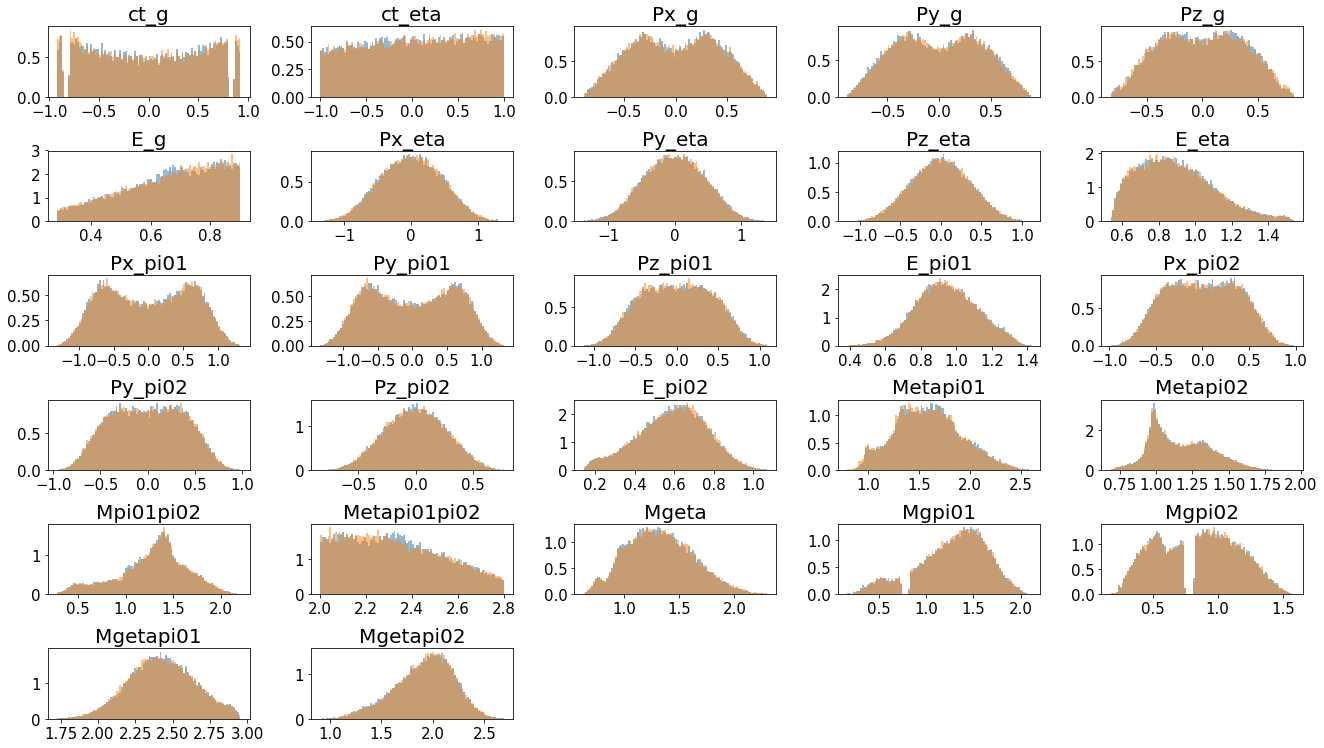

In [10]:
draw_distributions(phsp_ori_draw, data_ori_draw,weight_phsp,'phsp_target_xgboost.pdf')

In [11]:
from sklearn.model_selection import KFold,GridSearchCV
Error=[]
Effi=[]
randn=np.random.RandomState(22222)
kf=KFold(n_splits=10,shuffle=True,random_state=randn)
for train_index, test_index in kf.split(train_X):
    xgk_train = xgb.DMatrix(train_X[train_index], label=train_Y[train_index])
    xgk_test = xgb.DMatrix(train_X[test_index], label=train_Y[test_index])
    
    print train_X[train_index],train_Y[train_index]
    # setup parameters for xgboost
    params = {}
    # use softmax multi-class classification
    params['objective'] = 'multi:softmax'
    # scale weight of positive examples
    params['eta'] = 0.1
    params['max_depth'] = 6
    params['silent'] = 1
    params['nthread'] = 4
    params['num_class'] = 2

    # do the same thing again, but output probabilities
    params['objective'] = 'multi:softprob'
    watchlist = [(xgk_train, 'train'), (xgk_test, 'test')]
    num_round = 200 # 迭代次数
    bst = xgb.train(params, xgk_train, num_round, watchlist)
    
    pred_prob = bst.predict(xgk_test).reshape(train_Y[test_index].shape[0], 2)
    pred_label = np.argmax(pred_prob, axis=1)
    error_rate = np.sum(pred_label != train_Y[test_index]) / train_Y[test_index].shape[0]
    
    pr_test=np.array(bst.predict(xg_test).reshape(test_Y.shape[0], 2))
    pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
    pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))
    
    weight_test=pr_test[:,1]/pr_test[:,0]
    weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
    weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]
    
    Error.append(error_rate);
    Effi.append(weight_phsp.sum()/weight_mctruth.sum());

[[ 0.541641    0.43299723  1.8791146  ...  1.4249252   1.3745612
   0.9493227 ]
 [-0.52414984 -0.85150677  1.4477285  ...  1.8907776   0.83434767
   1.2948773 ]
 [ 0.2436688   0.21463634  1.086997   ...  1.1169746   1.6570785
   1.4203867 ]
 ...
 [-0.1535355   0.84943956  1.7667872  ...  0.5834916   2.241854
   0.4179448 ]
 [-0.3540976   0.64227676  1.9495171  ...  1.057895    1.4898444
   0.8581348 ]
 [-0.2858443   0.7210047   1.6499219  ...  0.8976522   2.010737
   1.1627392 ]] [0 0 1 ... 1 0 1]
[0]	train-merror:0.342998	test-merror:0.354234
[1]	train-merror:0.342447	test-merror:0.352941
[2]	train-merror:0.337372	test-merror:0.350356
[3]	train-merror:0.336869	test-merror:0.351648
[4]	train-merror:0.340317	test-merror:0.352295
[5]	train-merror:0.337803	test-merror:0.351433
[6]	train-merror:0.336318	test-merror:0.35488
[7]	train-merror:0.335097	test-merror:0.351648
[8]	train-merror:0.334738	test-merror:0.350571
[9]	train-merror:0.33311	test-merror:0.348847
[10]	train-merror:0.331697	te

[160]	train-merror:0.283166	test-merror:0.341952
[161]	train-merror:0.282687	test-merror:0.342383
[162]	train-merror:0.282448	test-merror:0.342383
[163]	train-merror:0.282376	test-merror:0.342383
[164]	train-merror:0.282352	test-merror:0.342383
[165]	train-merror:0.281921	test-merror:0.342168
[166]	train-merror:0.281801	test-merror:0.342383
[167]	train-merror:0.281777	test-merror:0.342383
[168]	train-merror:0.28161	test-merror:0.342599
[169]	train-merror:0.28161	test-merror:0.342383
[170]	train-merror:0.281586	test-merror:0.342383
[171]	train-merror:0.281179	test-merror:0.342599
[172]	train-merror:0.280724	test-merror:0.342814
[173]	train-merror:0.280724	test-merror:0.34303
[174]	train-merror:0.280772	test-merror:0.342599
[175]	train-merror:0.280724	test-merror:0.342599
[176]	train-merror:0.280269	test-merror:0.342599
[177]	train-merror:0.28003	test-merror:0.342599
[178]	train-merror:0.279479	test-merror:0.342814
[179]	train-merror:0.278904	test-merror:0.344107
[180]	train-merror:0.278

[121]	train-merror:0.289104	test-merror:0.338505
[122]	train-merror:0.288888	test-merror:0.33872
[123]	train-merror:0.288721	test-merror:0.338289
[124]	train-merror:0.288673	test-merror:0.337858
[125]	train-merror:0.288601	test-merror:0.338074
[126]	train-merror:0.288386	test-merror:0.338289
[127]	train-merror:0.288122	test-merror:0.337858
[128]	train-merror:0.288026	test-merror:0.337858
[129]	train-merror:0.287524	test-merror:0.338936
[130]	train-merror:0.287141	test-merror:0.338505
[131]	train-merror:0.287093	test-merror:0.33872
[132]	train-merror:0.286614	test-merror:0.338936
[133]	train-merror:0.286542	test-merror:0.338936
[134]	train-merror:0.28647	test-merror:0.339151
[135]	train-merror:0.286255	test-merror:0.33872
[136]	train-merror:0.285848	test-merror:0.339151
[137]	train-merror:0.2858	test-merror:0.339151
[138]	train-merror:0.285776	test-merror:0.339367
[139]	train-merror:0.285441	test-merror:0.339797
[140]	train-merror:0.285034	test-merror:0.338936
[141]	train-merror:0.28481

[81]	train-merror:0.302943	test-merror:0.330532
[82]	train-merror:0.302631	test-merror:0.330748
[83]	train-merror:0.302488	test-merror:0.330748
[84]	train-merror:0.302416	test-merror:0.330748
[85]	train-merror:0.302344	test-merror:0.331179
[86]	train-merror:0.3022	test-merror:0.330963
[87]	train-merror:0.30232	test-merror:0.331394
[88]	train-merror:0.30165	test-merror:0.331179
[89]	train-merror:0.301362	test-merror:0.330317
[90]	train-merror:0.30086	test-merror:0.329886
[91]	train-merror:0.300261	test-merror:0.329239
[92]	train-merror:0.299758	test-merror:0.329239
[93]	train-merror:0.299543	test-merror:0.329239
[94]	train-merror:0.299088	test-merror:0.329455
[95]	train-merror:0.298537	test-merror:0.32967
[96]	train-merror:0.298298	test-merror:0.329886
[97]	train-merror:0.298226	test-merror:0.329886
[98]	train-merror:0.298178	test-merror:0.329886
[99]	train-merror:0.29813	test-merror:0.330317
[100]	train-merror:0.297723	test-merror:0.330101
[101]	train-merror:0.297579	test-merror:0.3298

[41]	train-merror:0.313669	test-merror:0.341521
[42]	train-merror:0.313429	test-merror:0.340875
[43]	train-merror:0.31307	test-merror:0.340228
[44]	train-merror:0.312687	test-merror:0.340875
[45]	train-merror:0.311729	test-merror:0.339367
[46]	train-merror:0.311586	test-merror:0.339797
[47]	train-merror:0.311442	test-merror:0.340228
[48]	train-merror:0.310389	test-merror:0.339151
[49]	train-merror:0.31046	test-merror:0.339797
[50]	train-merror:0.310508	test-merror:0.340013
[51]	train-merror:0.309407	test-merror:0.341952
[52]	train-merror:0.309551	test-merror:0.342168
[53]	train-merror:0.309191	test-merror:0.342599
[54]	train-merror:0.309168	test-merror:0.342599
[55]	train-merror:0.309048	test-merror:0.342814
[56]	train-merror:0.308904	test-merror:0.34303
[57]	train-merror:0.308737	test-merror:0.343245
[58]	train-merror:0.308377	test-merror:0.343245
[59]	train-merror:0.308306	test-merror:0.343245
[60]	train-merror:0.307851	test-merror:0.34303
[61]	train-merror:0.30663	test-merror:0.3419

[1]	train-merror:0.339502	test-merror:0.371041
[2]	train-merror:0.339	test-merror:0.37061
[3]	train-merror:0.336007	test-merror:0.363068
[4]	train-merror:0.336701	test-merror:0.365438
[5]	train-merror:0.336558	test-merror:0.366085
[6]	train-merror:0.335384	test-merror:0.363284
[7]	train-merror:0.335001	test-merror:0.361775
[8]	train-merror:0.333589	test-merror:0.363284
[9]	train-merror:0.333613	test-merror:0.363068
[10]	train-merror:0.332966	test-merror:0.362206
[11]	train-merror:0.32983	test-merror:0.362206
[12]	train-merror:0.328872	test-merror:0.360267
[13]	train-merror:0.328058	test-merror:0.360483
[14]	train-merror:0.327005	test-merror:0.360483
[15]	train-merror:0.325736	test-merror:0.360052
[16]	train-merror:0.325951	test-merror:0.360267
[17]	train-merror:0.325736	test-merror:0.358328
[18]	train-merror:0.325592	test-merror:0.358112
[19]	train-merror:0.32406	test-merror:0.357897
[20]	train-merror:0.323988	test-merror:0.358328
[21]	train-merror:0.322767	test-merror:0.358328
[22]	tr

[172]	train-merror:0.281083	test-merror:0.358974
[173]	train-merror:0.280461	test-merror:0.359836
[174]	train-merror:0.280293	test-merror:0.359836
[175]	train-merror:0.279934	test-merror:0.358759
[176]	train-merror:0.279958	test-merror:0.358759
[177]	train-merror:0.279958	test-merror:0.358759
[178]	train-merror:0.279216	test-merror:0.358974
[179]	train-merror:0.278833	test-merror:0.35919
[180]	train-merror:0.27821	test-merror:0.357897
[181]	train-merror:0.277899	test-merror:0.357466
[182]	train-merror:0.277612	test-merror:0.357251
[183]	train-merror:0.2773	test-merror:0.357251
[184]	train-merror:0.277181	test-merror:0.357251
[185]	train-merror:0.276678	test-merror:0.357897
[186]	train-merror:0.276558	test-merror:0.357035
[187]	train-merror:0.276486	test-merror:0.357251
[188]	train-merror:0.276247	test-merror:0.357466
[189]	train-merror:0.275672	test-merror:0.357251
[190]	train-merror:0.275409	test-merror:0.357466
[191]	train-merror:0.275169	test-merror:0.357466
[192]	train-merror:0.275

[132]	train-merror:0.289415	test-merror:0.339797
[133]	train-merror:0.289152	test-merror:0.339582
[134]	train-merror:0.288793	test-merror:0.339367
[135]	train-merror:0.288338	test-merror:0.339582
[136]	train-merror:0.288026	test-merror:0.339582
[137]	train-merror:0.287404	test-merror:0.340444
[138]	train-merror:0.286757	test-merror:0.340013
[139]	train-merror:0.286757	test-merror:0.340013
[140]	train-merror:0.28671	test-merror:0.339797
[141]	train-merror:0.286183	test-merror:0.340013
[142]	train-merror:0.285991	test-merror:0.340228
[143]	train-merror:0.28556	test-merror:0.34109
[144]	train-merror:0.285345	test-merror:0.340875
[145]	train-merror:0.285105	test-merror:0.340659
[146]	train-merror:0.285034	test-merror:0.340659
[147]	train-merror:0.285034	test-merror:0.340659
[148]	train-merror:0.28477	test-merror:0.340444
[149]	train-merror:0.284315	test-merror:0.340228
[150]	train-merror:0.284124	test-merror:0.340228
[151]	train-merror:0.283956	test-merror:0.339797
[152]	train-merror:0.283

[92]	train-merror:0.300692	test-merror:0.339151
[93]	train-merror:0.300644	test-merror:0.339151
[94]	train-merror:0.29995	test-merror:0.339367
[95]	train-merror:0.299423	test-merror:0.340013
[96]	train-merror:0.298729	test-merror:0.340228
[97]	train-merror:0.298417	test-merror:0.340228
[98]	train-merror:0.298417	test-merror:0.340444
[99]	train-merror:0.298346	test-merror:0.340444
[100]	train-merror:0.298274	test-merror:0.340444
[101]	train-merror:0.29825	test-merror:0.340444
[102]	train-merror:0.298202	test-merror:0.340444
[103]	train-merror:0.297891	test-merror:0.34109
[104]	train-merror:0.297723	test-merror:0.340444
[105]	train-merror:0.29734	test-merror:0.341521
[106]	train-merror:0.296957	test-merror:0.341306
[107]	train-merror:0.296526	test-merror:0.340875
[108]	train-merror:0.296071	test-merror:0.341521
[109]	train-merror:0.295808	test-merror:0.342814
[110]	train-merror:0.295688	test-merror:0.342814
[111]	train-merror:0.295353	test-merror:0.342383
[112]	train-merror:0.294778	test

[51]	train-merror:0.310341	test-merror:0.342383
[52]	train-merror:0.310077	test-merror:0.342599
[53]	train-merror:0.309718	test-merror:0.34303
[54]	train-merror:0.309527	test-merror:0.343245
[55]	train-merror:0.309503	test-merror:0.342814
[56]	train-merror:0.30888	test-merror:0.343676
[57]	train-merror:0.308234	test-merror:0.342383
[58]	train-merror:0.307731	test-merror:0.342814
[59]	train-merror:0.3073	test-merror:0.342599
[60]	train-merror:0.307132	test-merror:0.342383
[61]	train-merror:0.307037	test-merror:0.342814
[62]	train-merror:0.307108	test-merror:0.342599
[63]	train-merror:0.30663	test-merror:0.342599
[64]	train-merror:0.306414	test-merror:0.342168
[65]	train-merror:0.306031	test-merror:0.342168
[66]	train-merror:0.305433	test-merror:0.342599
[67]	train-merror:0.304642	test-merror:0.342599
[68]	train-merror:0.304116	test-merror:0.342168
[69]	train-merror:0.304235	test-merror:0.342168
[70]	train-merror:0.304259	test-merror:0.342168
[71]	train-merror:0.304188	test-merror:0.3428

[11]	train-merror:0.33054	test-merror:0.339224
[12]	train-merror:0.328697	test-merror:0.339009
[13]	train-merror:0.329535	test-merror:0.341379
[14]	train-merror:0.329008	test-merror:0.33944
[15]	train-merror:0.328864	test-merror:0.338793
[16]	train-merror:0.32793	test-merror:0.336638
[17]	train-merror:0.327356	test-merror:0.338362
[18]	train-merror:0.326829	test-merror:0.337284
[19]	train-merror:0.325321	test-merror:0.337069
[20]	train-merror:0.324148	test-merror:0.335991
[21]	train-merror:0.323453	test-merror:0.336207
[22]	train-merror:0.323405	test-merror:0.337069
[23]	train-merror:0.322879	test-merror:0.336207
[24]	train-merror:0.322017	test-merror:0.336207
[25]	train-merror:0.321418	test-merror:0.33556
[26]	train-merror:0.321299	test-merror:0.334483
[27]	train-merror:0.320868	test-merror:0.334698
[28]	train-merror:0.319407	test-merror:0.334914
[29]	train-merror:0.319551	test-merror:0.334267
[30]	train-merror:0.31845	test-merror:0.332974
[31]	train-merror:0.318186	test-merror:0.3318

[182]	train-merror:0.277796	test-merror:0.338793
[183]	train-merror:0.277557	test-merror:0.339655
[184]	train-merror:0.277318	test-merror:0.33944
[185]	train-merror:0.276839	test-merror:0.339224
[186]	train-merror:0.276647	test-merror:0.338793
[187]	train-merror:0.276575	test-merror:0.339009
[188]	train-merror:0.276551	test-merror:0.339009
[189]	train-merror:0.27648	test-merror:0.339224
[190]	train-merror:0.276384	test-merror:0.339224
[191]	train-merror:0.276216	test-merror:0.339224
[192]	train-merror:0.27612	test-merror:0.339224
[193]	train-merror:0.276025	test-merror:0.339009
[194]	train-merror:0.275737	test-merror:0.338578
[195]	train-merror:0.275737	test-merror:0.338578
[196]	train-merror:0.275761	test-merror:0.338793
[197]	train-merror:0.275546	test-merror:0.338578
[198]	train-merror:0.275163	test-merror:0.338147
[199]	train-merror:0.275019	test-merror:0.338147
[[ 0.541641    0.43299723  1.8791146  ...  1.4249252   1.3745612
   0.9493227 ]
 [ 0.2436688   0.21463634  1.086997   ...

[142]	train-merror:0.285051	test-merror:0.343319
[143]	train-merror:0.284596	test-merror:0.343534
[144]	train-merror:0.284165	test-merror:0.343534
[145]	train-merror:0.283902	test-merror:0.343534
[146]	train-merror:0.283782	test-merror:0.343534
[147]	train-merror:0.283351	test-merror:0.343319
[148]	train-merror:0.282872	test-merror:0.343103
[149]	train-merror:0.282752	test-merror:0.343534
[150]	train-merror:0.282704	test-merror:0.343966
[151]	train-merror:0.282345	test-merror:0.343319
[152]	train-merror:0.282226	test-merror:0.343103
[153]	train-merror:0.28213	test-merror:0.343103
[154]	train-merror:0.281986	test-merror:0.342672
[155]	train-merror:0.281771	test-merror:0.342241
[156]	train-merror:0.281651	test-merror:0.342457
[157]	train-merror:0.281555	test-merror:0.342672
[158]	train-merror:0.281531	test-merror:0.342888
[159]	train-merror:0.281316	test-merror:0.342457
[160]	train-merror:0.28122	test-merror:0.342672
[161]	train-merror:0.281172	test-merror:0.342457
[162]	train-merror:0.2

In [12]:
print sum(Error)/10, sum(Effi)/10

0.3433458111361255 0.3109321594238281


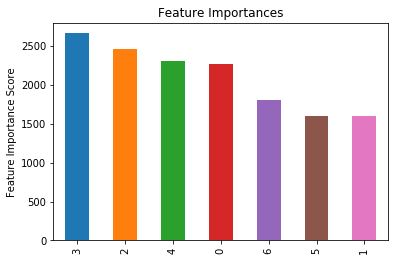

In [13]:
#print the importance score for each viriable
column_name=columns
#feat_imp = pd.Series(bst.get_fscore().values(),index=column_name).sort_values(ascending=False)  
feat_imp = pd.Series(bst.get_fscore().values()).sort_values(ascending=False)  
feat_imp.plot(kind='bar', title='Feature Importances')  
plt.ylabel('Feature Importance Score')  
plt.show()  

In [14]:
pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 2)
print pred_prob
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
print pred_label[0:20], test_Y[0:20] ,error_rate
print('Test error using softprob = {}'.format(error_rate))

[[0.31669414 0.68330586]
 [0.17186087 0.8281391 ]
 [0.539904   0.46009603]
 ...
 [0.28259948 0.7174005 ]
 [0.61282355 0.38717645]
 [0.54555345 0.4544465 ]]
[1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1] [1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0] 0.34283559577677225
Test error using softprob = 0.342835595777


In [15]:
#save the predict probility for each event
#f=open("xgb_predict.txt","wb")
#f1=open("xgb_input.txt","wb")
#pr=np.array(bst.predict(xg_val).reshape(val_Y.shape[0], 2)[:,1])
#np.savetxt(f,pr)
#np.savetxt(f,val_Y)
#np.savetxt(f1,val_X[:,0:2])

In [16]:
pr_test=np.array(bst.predict(xg_test).reshape(test_Y.shape[0], 2))
pr_phsp=np.array(bst.predict(xg_phsp_only).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(bst.predict(xg_mctruth_only).reshape(mctruth_only_Y.shape[0], 2))

In [17]:
weight_test=pr_test[:,1]/pr_test[:,0]
weight_phsp=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth=pr_mctruth[:,1]/pr_mctruth[:,0]

#save the weight for each event
f=open("xgb_weight.txt","wb")
np.savetxt(f,weight_phsp)

print 'The efficiency is = ',weight_phsp.sum()/weight_mctruth.sum()

The efficiency is =  0.31126928


In [18]:
pr_DIY_truth_all=np.array(bst.predict(xg_DIY_truth_all).reshape(DIY_truth_all_Y.shape[0], 2))
weight_DIY_truth_all=pr_DIY_truth_all[:,1]/pr_DIY_truth_all[:,0]
f=open("xgb_weight_DIY_truth_all.txt","wb")
np.savetxt(f,weight_DIY_truth_all)

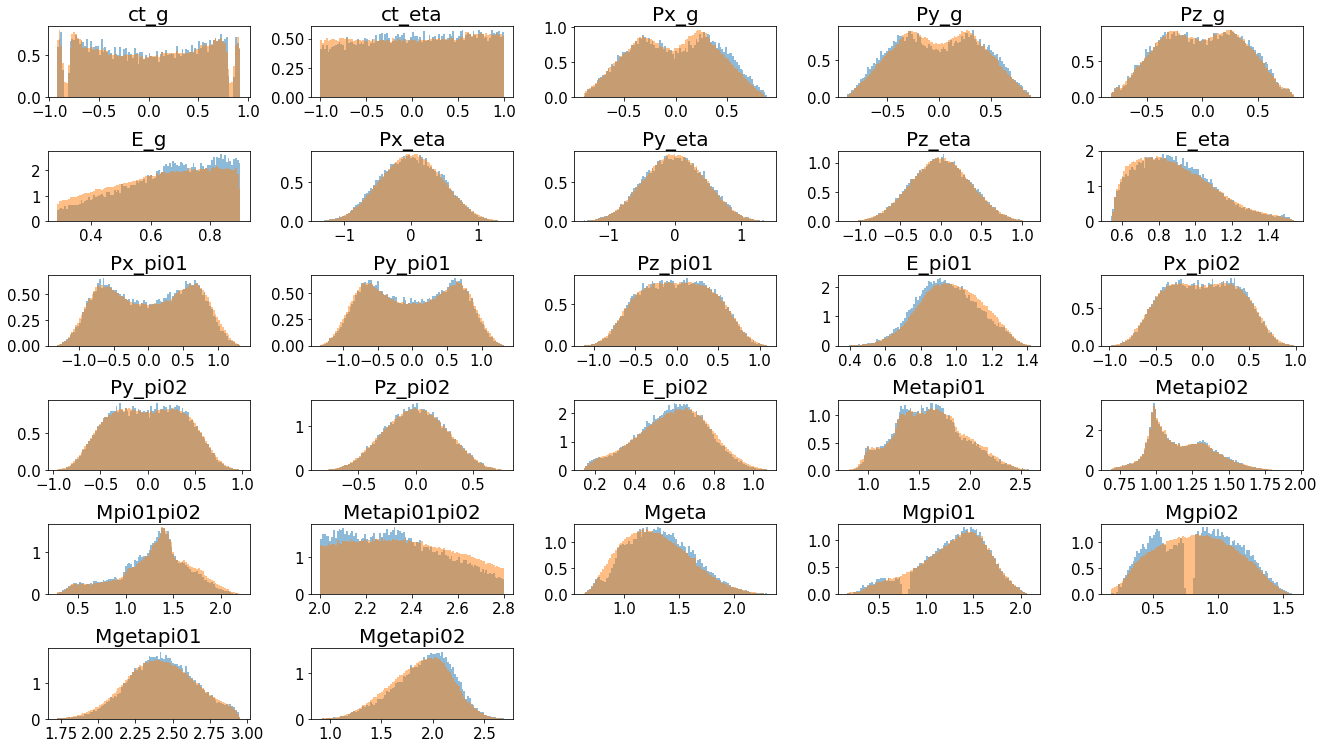

In [19]:
draw_distributions(DIY_truth_all_draw, data_ori_draw,weight_DIY_truth_all,'DIYtruth_target_xgboost.pdf')

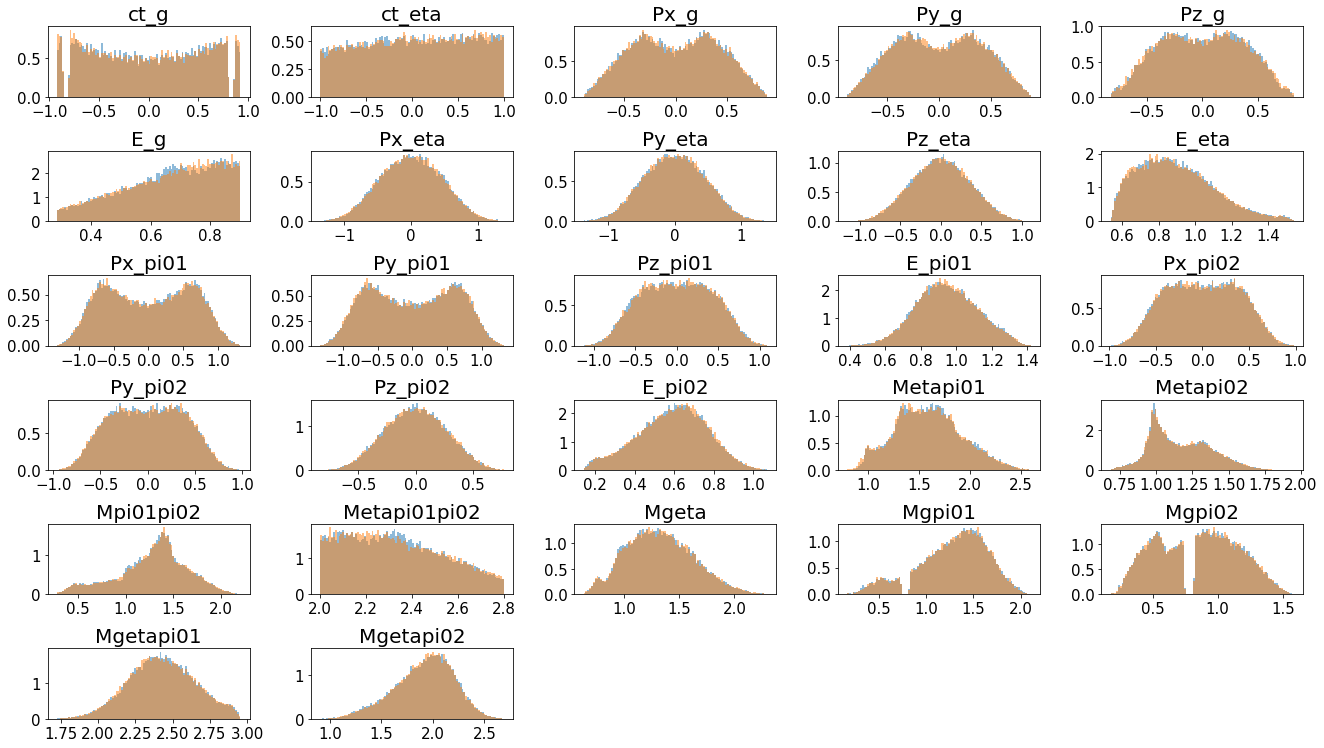

In [20]:
draw_distributions(phsp_ori_draw, data_ori_draw,weight_phsp,'phsp_target_xgboost.pdf')

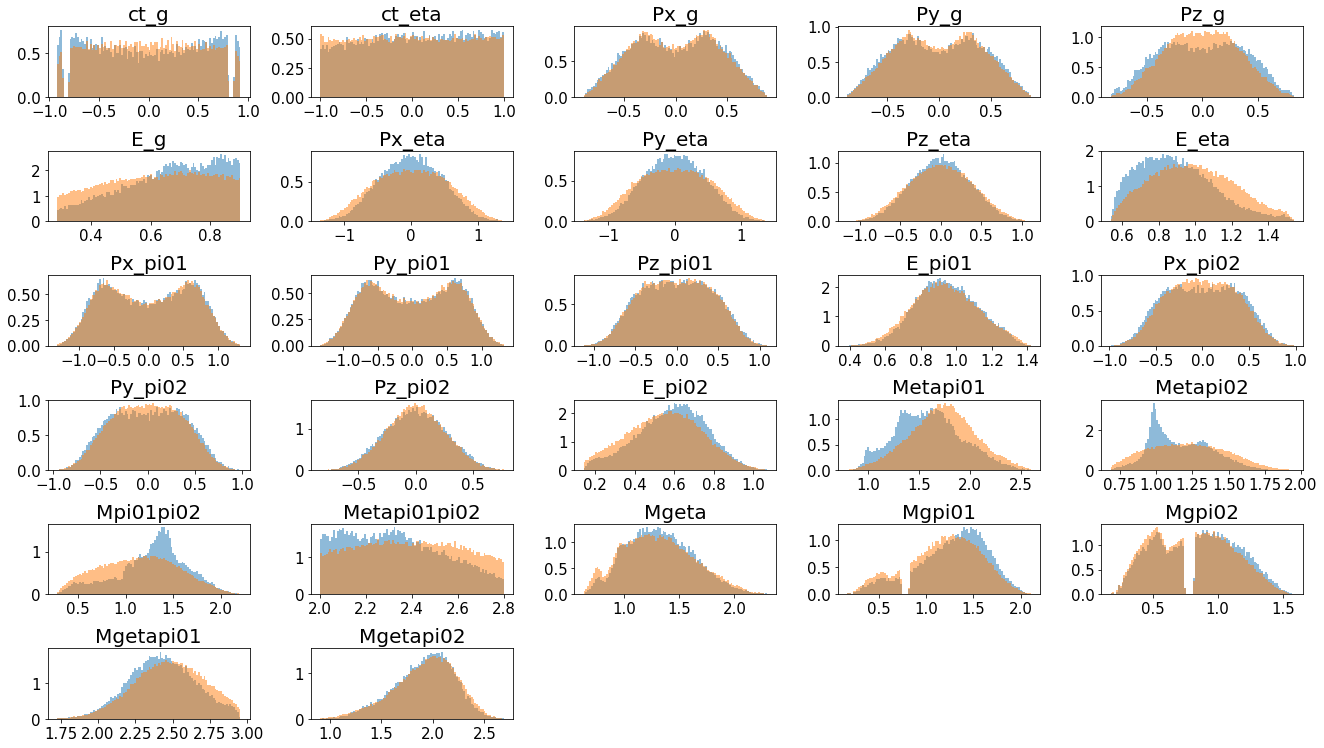

In [21]:
draw_distributions(phsp_ori_draw, data_ori_draw,original_weights,'phsp_target_xgboost.pdf')

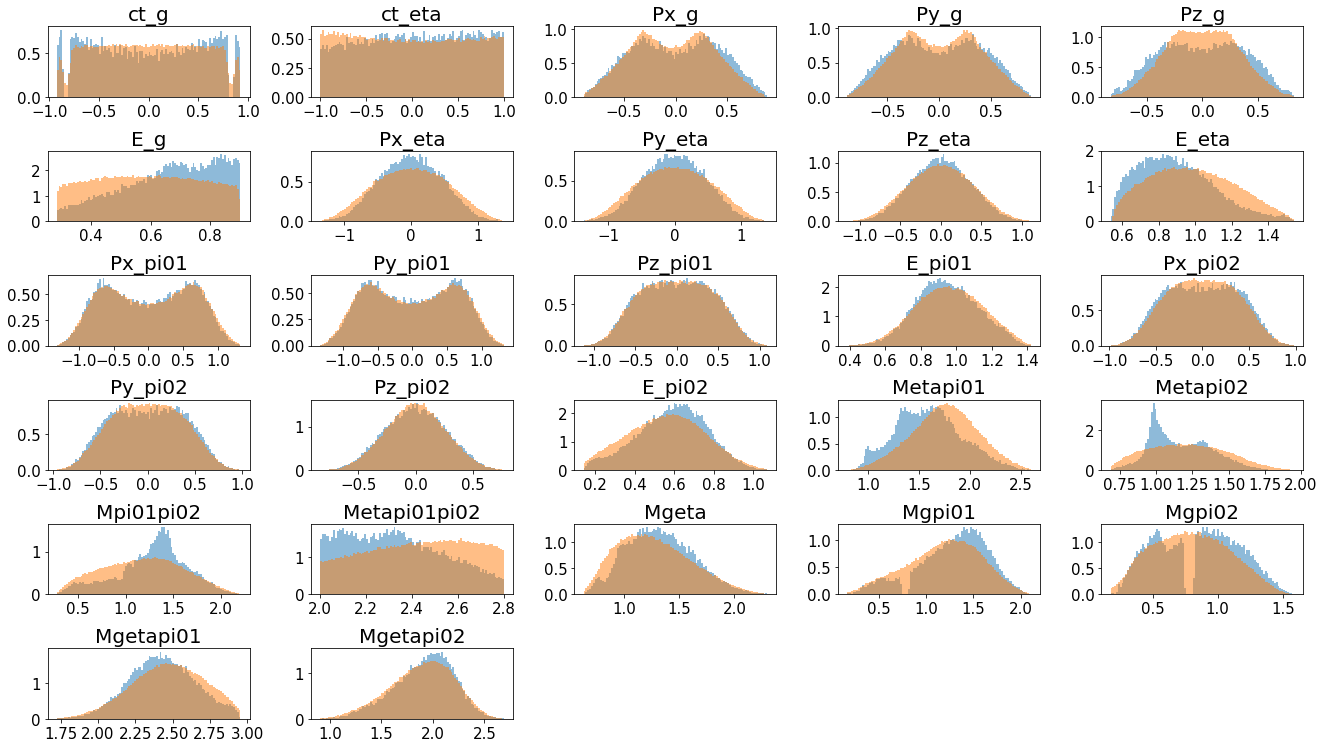

In [22]:
draw_distributions(mctruth_ori_draw, data_ori_draw,mctruth_weights,'phsp_target_ori.pdf')

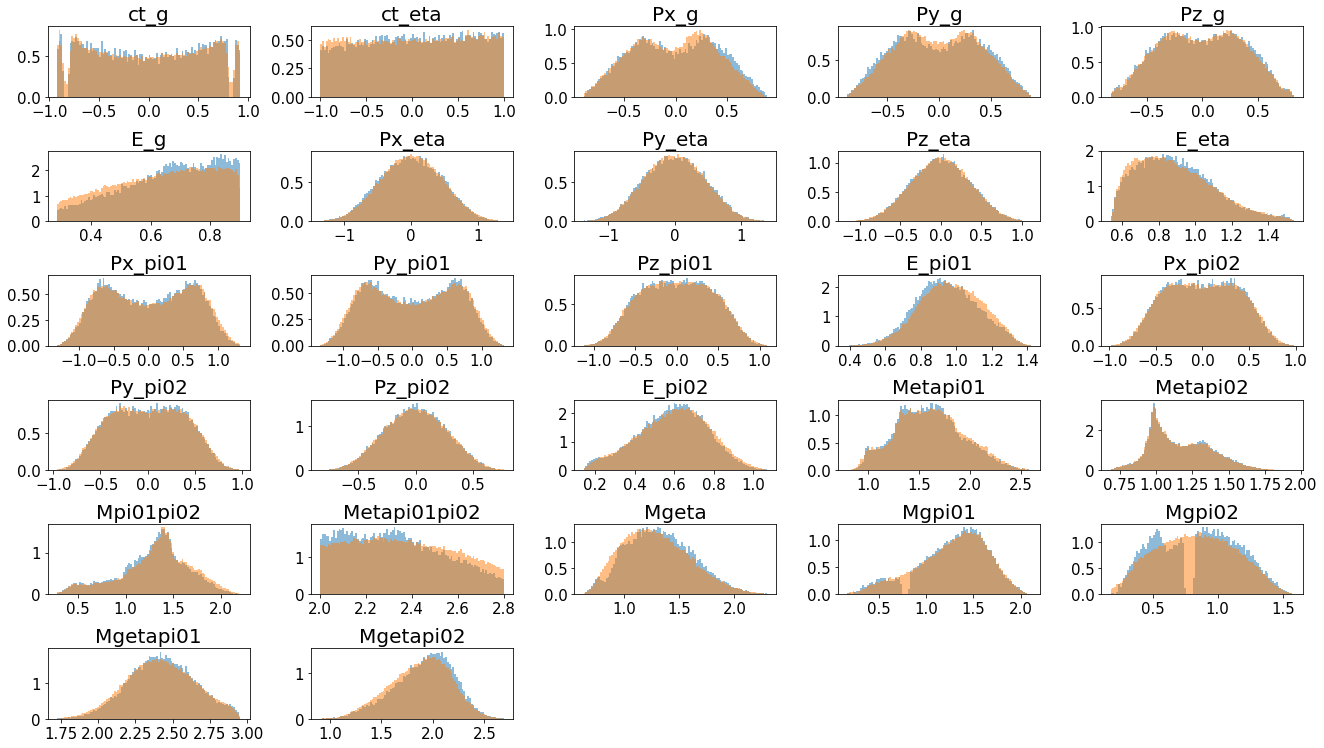

In [23]:
draw_distributions(mctruth_ori_draw, data_ori_draw,weight_mctruth,'phsp_target_ori.pdf')

## GBDT

error  = 0.34125188537
Efficient =  0.3121107625046713


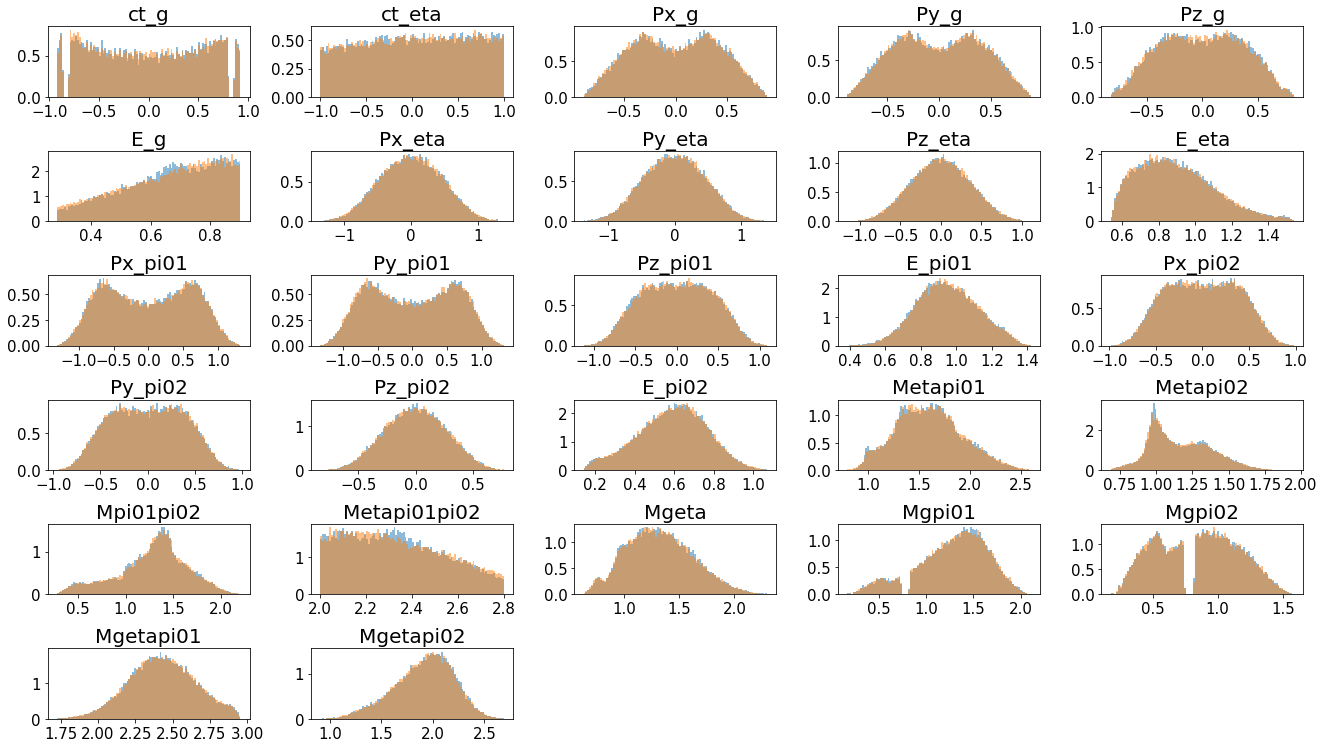

In [24]:
#from hep_ml import reweight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#data_gbdt = numpy.concatenate([original_train, target_train])
#labels_gbdt = numpy.array([0] * len(original_train) + [1] * len(target_train))


Xtr_gbdt, Xts_gbdt, Ytr_gbdt, Yts_gbdt = train_test_split(data_all, labels_all, random_state=42, train_size=0.8)
clf_gbdt = GradientBoostingClassifier().fit(Xtr_gbdt, Ytr_gbdt)

pred_label = np.argmax(clf_gbdt.predict_proba(Xts_gbdt), axis=1)
error_rate_val = np.sum(pred_label != Yts_gbdt) / Yts_gbdt.shape[0]
print('error  = {}'.format(error_rate_val))
    
pr_phsp=np.array(clf_gbdt.predict_proba(phsp_only_X).reshape(phsp_only_Y.shape[0], 2))
pr_mctruth=np.array(clf_gbdt.predict_proba(mctruth_only_X).reshape(mctruth_only_Y.shape[0], 2))
weight_phsp_GBT=pr_phsp[:,1]/pr_phsp[:,0]
weight_mctruth_GBT=pr_mctruth[:,1]/pr_mctruth[:,0]
print "Efficient = ", weight_phsp_GBT.sum()/weight_mctruth_GBT.sum()

draw_distributions(phsp_ori_draw, data_ori_draw,weight_phsp_GBT,'phsp_target_GBT.pdf')

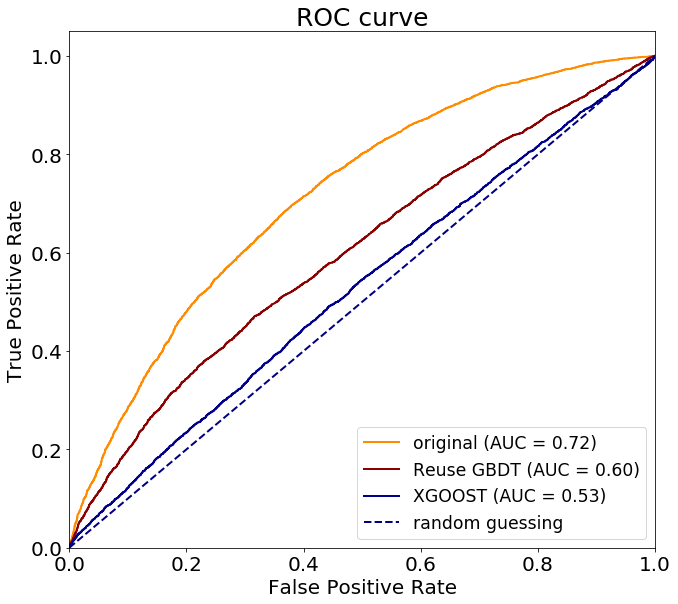

In [25]:
#from hep_ml import reweight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#for paper
#gb_weights_test = reweighter.predict_weights(original_test)

    
data = data_all
labels = labels_all

#get the weight factor for xgb_model
xgb_X = np.array(phsp_train)
xgb_Y = numpy.array([0] * len(xgb_X))
xg_phsp = xgb.DMatrix(xgb_X, label=xgb_Y)
pr_phsp_xgb=np.array(bst.predict(xg_phsp))
weight_xgb=pr_phsp_xgb[:,1]/pr_phsp_xgb[:,0]

#for sklearn gbdt
pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train).reshape(phsp_train.shape[0], 2))
#pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train))
gbdt_weights_test=pr_phsp_gbdt[:,1]/pr_phsp_gbdt[:,0]
#draw_distributions(phsp_train_draw, data_ori_draw,gbdt_weights_test,'test.pdf')


#new_weights=original_weights_test
#W = numpy.concatenate([new_weights / new_weights.sum() * len(phsp_only_X), [1] * len(data_only_X)])
W = numpy.concatenate([[1] * len(data_train),[1]*len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
    
clf_ori = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
fpr_ori, tpr_ori, thresholds_ori = metrics.roc_curve(Yts,clf_ori.predict_proba(Xts)[:, 1])

new_weights=weight_xgb
W = numpy.concatenate([[1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
clf_xgb_t = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(Yts,clf_xgb_t.predict_proba(Xts)[:, 1])

new_weights=gbdt_weights_test
W = numpy.concatenate([ [1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
clf_gbdt_t = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
fpr_gbdt, tpr_gbdt, thresholds_gbdt = metrics.roc_curve(Yts,clf_gbdt_t.predict_proba(Xts)[:, 1])


#fpr, tpr, thresholds = metrics.roc_curve(Yts,Yts)
plt.figure().set_size_inches(10.5, 9.5)
#plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='xgboost (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot(fpr_ori,tpr_ori,lw=2, color='darkorange',label='original (AUC = %0.2f)' % metrics.auc(fpr_ori,tpr_ori))
plt.plot(fpr_gbdt,tpr_gbdt,lw=2, color='darkred',label='Reuse GBDT (AUC = %0.2f)' % metrics.auc(fpr_gbdt,tpr_gbdt))
plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='XGOOST (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot([0, 1], [0, 1], color='navy',label='random guessing',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC curve',fontsize=25)                                                                                                  
plt.legend(loc="lower right",fontsize='xx-large')

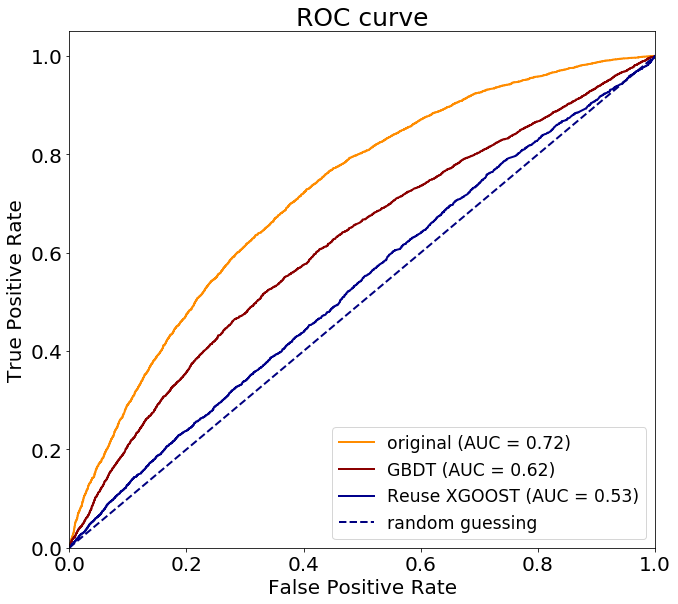

In [26]:
#from hep_ml import reweight
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import roc_auc_score
#from sklearn import metrics

#for paper
#gb_weights_test = reweighter.predict_weights(original_test)

    
data = data_all
labels = labels_all

#get the weight factor for xgb_model
xgb_X = np.array(phsp_train)
xgb_Y = numpy.array([0] * len(xgb_X))
xg_phsp = xgb.DMatrix(xgb_X, label=xgb_Y)
pr_phsp_xgb=np.array(bst.predict(xg_phsp))
weight_xgb=pr_phsp_xgb[:,1]/pr_phsp_xgb[:,0]

#for sklearn gbdt
pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train).reshape(phsp_train.shape[0], 2))
#pr_phsp_gbdt=np.array(clf_gbdt.predict_proba(phsp_train))
gbdt_weights_test=pr_phsp_gbdt[:,1]/pr_phsp_gbdt[:,0]
#draw_distributions(phsp_train_draw, data_ori_draw,gbdt_weights_test,'test.pdf')


#new_weights=original_weights_test
#W = numpy.concatenate([new_weights / new_weights.sum() * len(phsp_only_X), [1] * len(data_only_X)])
W = numpy.concatenate([[1] * len(data_train),[1]*len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
    
xgboost_ori = xgb.XGBClassifier().fit(Xtr, Ytr, sample_weight=Wtr)
fpr_ori, tpr_ori, thresholds_ori = metrics.roc_curve(Yts,xgboost_ori.predict_proba(Xts)[:, 1])

new_weights=weight_xgb
W = numpy.concatenate([[1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
xgboost_xgb_t = xgb.XGBClassifier().fit(Xtr, Ytr, sample_weight=Wtr)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(Yts,xgboost_xgb_t.predict_proba(Xts)[:, 1])

new_weights=gbdt_weights_test
W = numpy.concatenate([ [1] * len(data_train),new_weights / new_weights.sum() * len(phsp_train)])
Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.8)
xgboost_gbdt_t = xgb.XGBClassifier().fit(Xtr, Ytr, sample_weight=Wtr)
fpr_gbdt, tpr_gbdt, thresholds_gbdt = metrics.roc_curve(Yts,xgboost_gbdt_t.predict_proba(Xts)[:, 1])


#fpr, tpr, thresholds = metrics.roc_curve(Yts,Yts)
plt.figure().set_size_inches(10.5, 9.5)
#plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='xgboost (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot(fpr_ori,tpr_ori,lw=2, color='darkorange',label='original (AUC = %0.2f)' % metrics.auc(fpr_ori,tpr_ori))
plt.plot(fpr_gbdt,tpr_gbdt,lw=2, color='darkred',label='GBDT (AUC = %0.2f)' % metrics.auc(fpr_gbdt,tpr_gbdt))
plt.plot(fpr_xgb,tpr_xgb,lw=2, color='darkblue',label='Reuse XGOOST (AUC = %0.2f)' % metrics.auc(fpr_xgb,tpr_xgb))
plt.plot([0, 1], [0, 1], color='navy',label='random guessing',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC curve',fontsize=25)                                                                                                  
plt.legend(loc="lower right",fontsize='xx-large')